<a href="https://colab.research.google.com/github/ngonhan2k5/cs-ml/blob/master/proj1/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare dataset

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Load data**

In [260]:
#load data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', skipinitialspace=True, na_values="?")
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 
                     'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                     'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
#df.describe()
df.sample(4)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
11272,40,Self-emp-not-inc,33658,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
14209,54,Private,256908,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,25,United-States,>50K
17522,51,Private,122288,Some-college,10,Widowed,Machine-op-inspct,Unmarried,White,Female,0,0,36,United-States,<=50K
11817,36,State-gov,108320,Masters,14,Divorced,Prof-specialty,Unmarried,White,Male,5455,0,30,United-States,<=50K


**Clean up data**

In [261]:
#remove records missing values
no_missing_df= df.drop(df[df.native_country.isnull()].index)
no_missing_df= no_missing_df.drop(no_missing_df[no_missing_df.workclass.isnull()].index)
no_missing_df= no_missing_df.drop(no_missing_df[no_missing_df.occupation.isnull()].index)
no_missing_df.isnull().sum().max() #just checking that there's no missing data missing...

0

In [262]:
#LabelEncoder
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
no_missing_df['workclass_num']= le.fit_transform(no_missing_df['workclass'])
no_missing_df['marital_status_num']= le.fit_transform(no_missing_df['marital_status'])
no_missing_df['occupation_num']= le.fit_transform(no_missing_df['occupation'])
no_missing_df['relationship_num']= le.fit_transform(no_missing_df['relationship'])
no_missing_df['race_num']= le.fit_transform(no_missing_df['race'])
no_missing_df['sex_num']= le.fit_transform(no_missing_df['sex'])
no_missing_df['native_country_num']= le.fit_transform(no_missing_df['native_country'])
no_missing_df['income_num']= le.fit_transform(no_missing_df['income'])

#.columns

In [263]:
#remove the unnecessary features
neccessary_columns_df= no_missing_df.drop(columns=['fnlwgt', 'education', 'workclass', 'income', 'marital_status', 'occupation', 'sex', 'relationship', 'native_country', 'race'])
#neccessary_columns_df.columns

In [264]:
#separate input and target
input_df= neccessary_columns_df.drop('income_num', axis='columns')
target_df= neccessary_columns_df['income_num']

**Split data into Training and Testing**

In [265]:
#Split data into Training and Testing dataframe
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_df, target_df, test_size=0.3, random_state=0)
print("Training Data:", X_train.shape, y_train.shape)
print("Testing Data :", X_test.shape, y_test.shape)

Training Data: (21112, 12) (21112,)
Testing Data : (9049, 12) (9049,)


# 2. Training Model using Decision Tree Classifier

**Tuning Hyper-Parameter to find the best parameters**

In [266]:
from sklearn.model_selection import GridSearchCV
def get_the_GridSearcCV(model, param_dist, X, y):
  gs= GridSearchCV(model, param_dist)
  gs.fit(X, y)
  print('Tuning Hyper-Parameters:')
  print('  - The best parameters: ', gs.best_params_)
  print('  - The best score: ', gs.best_score_)
  return gs

In [267]:
#Tuning hyper-parameters by using GridSearchCV
from sklearn.tree import DecisionTreeClassifier
param_dist= {'criterion': ['gini','entropy'],
             'max_depth': [1,2,3,4,5,6,7,8,9],
             'min_samples_leaf': [2,3,4],
             'min_samples_split': [4,5,6,7,8,9]
             }
gs= get_the_GridSearcCV(DecisionTreeClassifier(), param_dist,  input_df, target_df)

Tuning Hyper-Parameters:
  - The best parameters:  {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 8}
  - The best score:  0.852060781088628


**Apply the best parameters to train the model**
*   The best parameters:  {**'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 8**}
*   The best score     :  0.8521602395929374


In [336]:
best_clf= DecisionTreeClassifier(criterion= 'gini', max_depth=9, min_samples_leaf=3, min_samples_split=8)
best_clf= best_clf.fit(X_train, y_train)
score= best_clf.score(X_test, y_test)
print("Test score: ", score)

Test score:  0.8471654326444911


**The confusion matrix**
*   Apply the trained model to predict the Test set

In [269]:
#predict Testing set
y_predict= best_clf.predict(X_test)

#Show confusion matrix
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, y_predict)
confusion_df= pd.DataFrame(cm)
print("Confussion Matrix when apply the best model to the Test data")
confusion_df

Confussion Matrix when apply the best model to the Test data


,0,1
0,6492,378
1,1003,1176


**Precision, Recall, F1-score**

In [334]:
# Precision, Recall, F1-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      6870
           1       0.76      0.54      0.63      2179

    accuracy                           0.85      9049
   macro avg       0.81      0.74      0.77      9049
weighted avg       0.84      0.85      0.84      9049



# 3. Learning Curve and Validation Curve

In [320]:
def show_curve(train_scores, test_scores, title):
  train_scores_mean= np.mean(train_scores, axis=1)
  train_scores_std= np.std(train_scores, axis=1)
  test_scores_mean= np.mean(test_scores, axis=1)
  test_scores_std= np.std(test_scores, axis=1)

  plt.plot(train_sizes, train_scores_mean, marker='o', label= "Training score")
  plt.plot(train_sizes, test_scores_mean, marker='o', label="Cross-Validation score")

  plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,color= '#33F4FF',alpha=0.5)
  plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, color= '#DDDDDD',alpha=0.5)

  plt.title(title)
  plt.xlabel('Training Size')
  plt.ylabel('Score')
  plt.legend(loc= 'best')

In [314]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
param_name="max_depth"
param_range = np.linspace(0.01,1,20)
train_sizes= np.linspace(0.01,1,20)
scoring= 'accuracy'

**1. The best model**

Hyper-parameters= {**'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 8**}

In [337]:
score= best_clf.score(X_test, y_test)
print("Test score: ", score)

Test score:  0.8471654326444911


[learning_curve] Training set sizes: [  241  1498  2755  4012  5270  6527  7784  9041 10298 11556 12813 14070
 15327 16584 17842 19099 20356 21613 22870 24128]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished


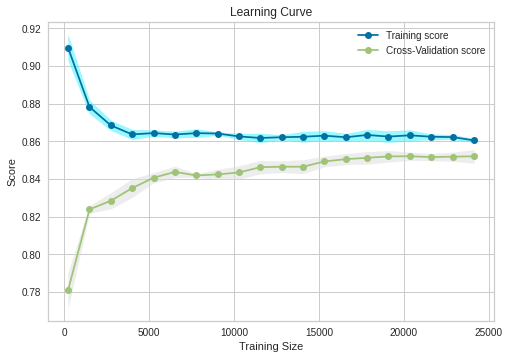

In [321]:
train_sizes, train_scores, test_scores= learning_curve(best_clf, input_df, target_df, scoring=scoring, train_sizes= train_sizes, verbose=1)
show_curve(train_scores, test_scores, 'Learning Curve')

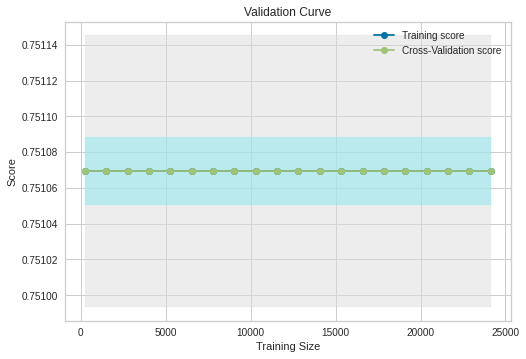

In [322]:
train_scores, test_scores= validation_curve(best_clf, input_df, target_df, param_name=param_name, param_range=param_range, scoring= scoring)
show_curve(train_scores, test_scores, 'Validation Curve')

**2. The second model**

Hyper-parameters= {**'criterion': 'gini', 'max_depth': 15**}

In [323]:
second_clf= DecisionTreeClassifier(criterion= 'gini', max_depth=15)
second_clf= second_clf.fit(X_train, y_train)
score= second_clf.score(X_test, y_test)
print("Test score: ", score)

Test score:  0.8363355066858217


[learning_curve] Training set sizes: [  241  1498  2755  4012  5270  6527  7784  9041 10298 11556 12813 14070
 15327 16584 17842 19099 20356 21613 22870 24128]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.6s finished


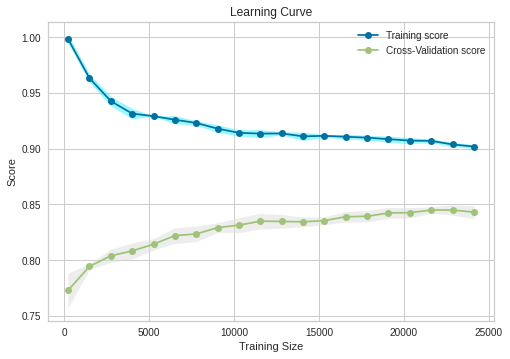

In [324]:
train_sizes, train_scores, test_scores= learning_curve(second_clf, input_df, target_df, scoring=scoring, train_sizes= train_sizes, verbose=1)
show_curve(train_scores, test_scores, 'Learning Curve')

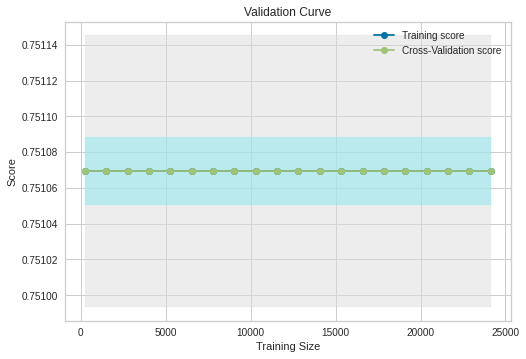

In [326]:
train_scores, test_scores= validation_curve(second_clf, input_df, target_df, param_name=param_name, param_range=param_range, scoring=scoring)
show_curve(train_scores, test_scores, 'Validation Curve')

**3. The third model**

Hyper-parameters= {**'criterion': 'entropy'**}

In [330]:
third_clf= DecisionTreeClassifier(criterion= 'entropy')
third_clf= third_clf.fit(X_train, y_train)
score= third_clf.score(X_test, y_test)
print("Test score: ", score)

Test score:  0.8124654657973257


[learning_curve] Training set sizes: [  241  1498  2755  4012  5270  6527  7784  9041 10298 11556 12813 14070
 15327 16584 17842 19099 20356 21613 22870 24128]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished


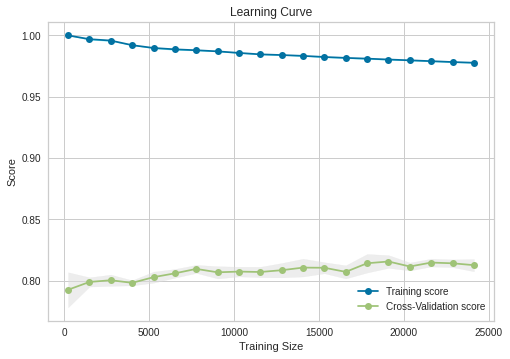

In [332]:
train_sizes, train_scores, test_scores= learning_curve(third_clf, input_df, target_df, scoring=scoring, train_sizes= train_sizes, verbose=1)
show_curve(train_scores, test_scores, 'Learning Curve')

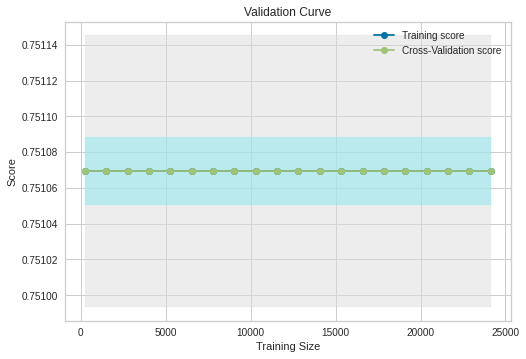

In [333]:
train_scores, test_scores= validation_curve(third_clf, input_df, target_df, param_name=param_name, param_range=param_range, scoring=scoring)
show_curve(train_scores, test_scores, 'Validation Curve')